# Section 5.5 — Hierarchical models

This notebook contains the code examples from [Section 5.5 Hierarchical models]() from the **No Bullshit Guide to Statistics**.

See also:
- [03_hierarchical_model.ipynb](http://localhost:8888/lab/tree/notebooks/explorations/bambi-paper-main/original/03_hierarchical_model.ipynb)
- https://github.com/fonnesbeck/pymc_sdss_2024/blob/main/notebooks/Section4-Hierarchical_Models.ipynb
- 

#### Notebook setup

In [1]:
# load Python modules
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Figures setup
plt.clf()  # needed otherwise `sns.set_theme` doesn"t work
from plot_helpers import RCPARAMS
RCPARAMS.update({"figure.figsize": (5, 3)})   # good for screen
# RCPARAMS.update({"figure.figsize": (5, 1.6)})  # good for print
sns.set_theme(
    context="paper",
    style="whitegrid",
    palette="colorblind",
    rc=RCPARAMS,
)

# High-resolution please
%config InlineBackend.figure_format = "retina"

# Where to store figures
DESTDIR = "figures/bayes/hierarchical"

<Figure size 640x480 with 0 Axes>

In [3]:
# set random seed for repeatability
np.random.seed(42)
#######################################################

## Definitions

## Model

## Example: radon levels

https://bambinos.github.io/bambi/notebooks/radon_example.html

- Description: Contains measurements of radon levels in homes across various counties.
- Source: Featured in Andrew Gelman and Jennifer Hill's book Data Analysis Using Regression and Multilevel/Hierarchical Models.
- Application: Demonstrates partial pooling and varying intercepts/slopes in hierarchical modeling.


### Data

In [4]:
radon = pd.read_csv("../datasets/radon.csv")
radon.groupby("county")["log_u"].count().sort_values()

county
WILKIN               1
MAHNOMEN             1
MURRAY               1
YELLOW MEDICINE      2
LAC QUI PARLE        2
                  ... 
WASHINGTON          46
ANOKA               52
DAKOTA              63
HENNEPIN           105
ST LOUIS           116
Name: log_u, Length: 85, dtype: int64

### Bayesian model
TODO: add formulas

### Bambi model

In [5]:
import bambi as bmb
covariate_priors = {
    "floor": bmb.Prior("Normal", mu=0, sigma=10),
    "log_u": bmb.Prior("Normal", mu=0, sigma=10),
    "floor|county": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("Exponential", lam=1)),
    "sigma": bmb.Prior("Exponential", lam=1),
}

covariate_model = bmb.Model(
    formula="log_radon ~ 0 + floor + log_u + (0 + floor|county)",
    priors=covariate_priors,
    data=radon,
    noncentered=True
 )

covariate_model

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


       Formula: log_radon ~ 0 + floor + log_u + (0 + floor|county)
        Family: gaussian
          Link: mu = identity
  Observations: 919
        Priors: 
    target = mu
        Common-level effects
            floor ~ Normal(mu: 0.0, sigma: 10.0)
            log_u ~ Normal(mu: 0.0, sigma: 10.0)
        
        Group-level effects
            floor|county ~ Normal(mu: 0.0, sigma: Exponential(lam: 1.0))
        
        Auxiliary parameters
            sigma ~ Exponential(lam: 1.0)

### Model fitting and analysis

In [6]:
covariate_results = covariate_model.fit(
    draws=2000, 
    tune=2000,
    target_accept=0.9,
    chains=4,
)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, floor, log_u, floor|county_sigma, floor|county_offset]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 8 seconds.


### Compare to previous results

### Conclusions

## Explanations

## Discussion

## Exercises

## Links

## EXTRA MATERIAL

### Radon levels

cf. https://github.com/mitzimorris/brms_feb_28_2023/blob/main/brms_notebook.Rmd

In [7]:
mn_radon = pd.read_csv("../datasets/mn_radon.csv")
# radon["county_id"] = radon["county_id"].astype('category')
mn_radon

,floor,county,log_radon,log_uranium,county_id
0,1,AITKIN,0.788457,-0.689048,1
1,0,AITKIN,0.788457,-0.689048,1
2,0,AITKIN,1.064711,-0.689048,1
3,0,AITKIN,0.000000,-0.689048,1
4,0,ANOKA,1.131402,-0.847313,2
...,...,...,...,...,...
914,0,WRIGHT,1.856298,-0.090024,84
915,0,WRIGHT,1.504077,-0.090024,84
916,0,WRIGHT,1.609438,-0.090024,84
917,0,YELLOW MEDICINE,1.308333,0.355287,85


#### ALT manually downloaod radon

In [8]:
# # Get radon data
# path = "https://raw.githubusercontent.com/pymc-devs/pymc-examples/main/examples/data/srrs2.dat"
# radon_df = pd.read_csv(path)

# import pymc as pm
# # Get city data
# city_df = pd.read_csv(pm.get_data("cty.dat"))

# # Strip spaces from column names
# radon_df.columns = radon_df.columns.map(str.strip)

# # Filter to keep observations for "MN" state only
# df = radon_df[radon_df.state == "MN"].copy()
# city_mn_df = city_df[city_df.st == "MN"].copy()

# # Compute fips
# df["fips"] = 1_000 * df.stfips + df.cntyfips
# city_mn_df["fips"] = 1_000 * city_mn_df.stfips + city_mn_df.ctfips

# # Merge data
# df = df.merge(city_mn_df[["fips", "Uppm"]], on="fips")
# df = df.drop_duplicates(subset="idnum")

# # Clean county names
# df.county = df.county.map(str.strip)

# # Compute log(radon + 0.1)
# df["log_radon"] = np.log(df["activity"] + 0.1)

# # Compute log of Uranium
# df["log_u"] = np.log(df["Uppm"])

# # Let's map floor. 0 -> Basement and 1 -> Floor
# df["floor"] = df["floor"].map({0: "basement", 1: "ground"})

# # Sort values by floor
# df = df.sort_values(by="floor")

# # Reset index
# df = df.reset_index(drop=True)
# df

# radon = df[["idnum", "state", "county", "floor", "log_radon", "log_u"]]
# radon.to_csv("../datasets/radon.csv", index=False)

In [9]:
import bambi as bmb

#### Complete pooling

In [10]:
mod_cp = bmb.Model("log_radon ~ 1 + C(floor)", data=mn_radon)

In [11]:
mod_cp

       Formula: log_radon ~ 1 + C(floor)
        Family: gaussian
          Link: mu = identity
  Observations: 919
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 1.2246, sigma: 2.3354)
            C(floor) ~ Normal(mu: 0.0, sigma: 5.7237)
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 0.8529)

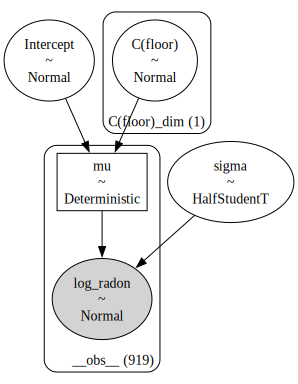

In [12]:
mod_cp.build()
mod_cp.graph()

In [13]:
idata_cp = mod_cp.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, C(floor)]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


In [14]:
import arviz as az

az.summary(idata_cp)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
C(floor)[1],-0.614,0.074,-0.756,-0.480,0.001,0.001,6146.0,3038.0,1.0
Intercept,1.326,0.030,1.268,1.379,0.000,0.000,5576.0,3154.0,1.0
sigma,0.823,0.019,0.789,0.860,0.000,0.000,6248.0,3292.0,1.0


/Users/ivan/Projects/Minireference/STATSbook/noBSstatsnotebooks/venv/lib/python3.12/site-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(
Default computed for conditional variable: floor


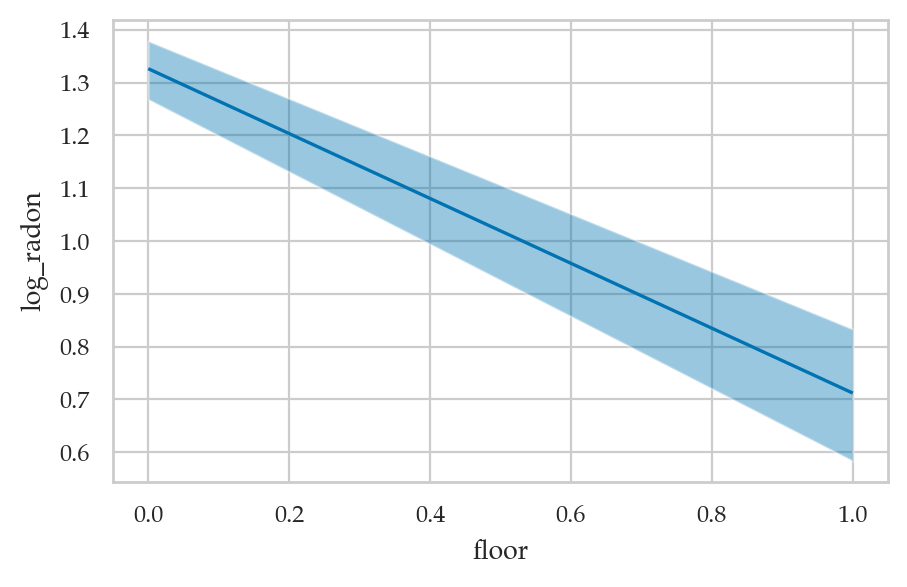

In [15]:
bmb.interpret.plot_predictions(mod_cp, idata_cp, "floor");

#### No pooling

In [16]:
mod_np = bmb.Model("log_radon ~ 1 + C(floor) + C(county_id)", data=mn_radon)
# mod_np

In [17]:
idata_np = mod_np.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, C(floor), C(county_id)]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


/Users/ivan/Projects/Minireference/STATSbook/noBSstatsnotebooks/venv/lib/python3.12/site-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(
Default computed for conditional variable: floor, county_id


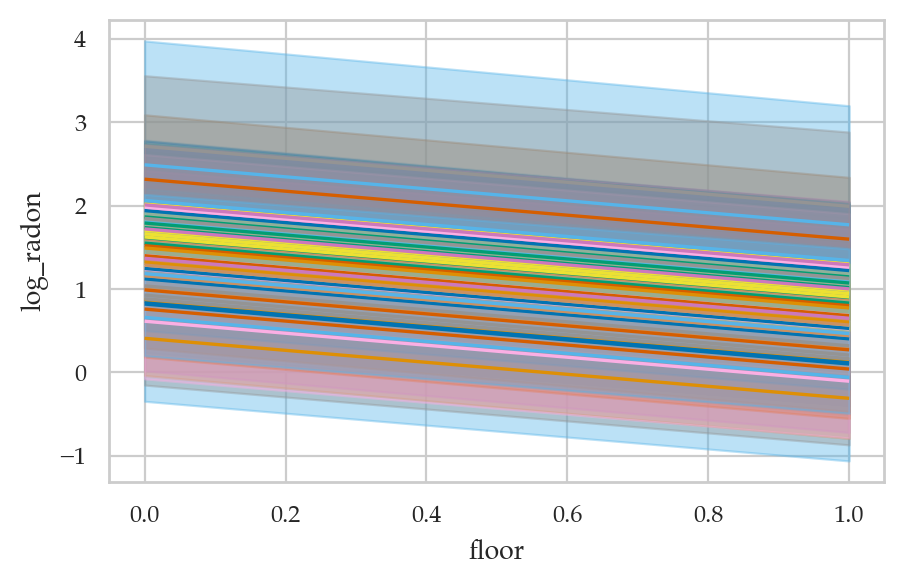

In [18]:
fig, axs = bmb.interpret.plot_predictions(mod_np, idata_np, ["floor", "county_id"]);
axs[0].get_legend().remove()

#### Partial Pooling Model: varying slope

The partial pooling formula estimates per-county intercepts which drawn
from the same distribution which is estimated jointly with the rest of
the model parameters. The `1` is the intercept co-efficient. The
estimates across counties will all have the same slope.


    log_radon ~ floor + (1 | county_id)


In [19]:
mod_pp1 = bmb.Model("log_radon ~ (1 | C(county_id)) + C(floor)", data=radon)
mod_pp1

KeyError: 'county_id'

In [ ]:
idata_pp1 = mod_pp1.fit()

In [ ]:
az.plot_forest(idata_pp1, var_names=["1|C(county_id)"], combined=True);

#### Partial Pooling Model 2: varying slope, varying intercept

The varying-slope, varying intercept model adds `floor` to the
group-level co-efficients. Now estimates across counties will all have
varying slope.

    log_radon ~ floor + (1 + floor | county_id)

In [ ]:
mod_pp2 = bmb.Model("log_radon ~ (1 + C(floor) | C(county_id))", data=mn_radon)
mod_pp2

In [ ]:
idata_pp2 = mod_pp2.fit()

In [ ]:
idata_pp2.posterior

In [ ]:
az.plot_forest(idata_pp2, var_names=["1|C(county_id)", "C(floor)|C(county_id)"], combined=True);

### Educaitonal data

cf. https://mc-stan.org/users/documentation/case-studies/tutorial_rstanarm.html

1.1 Data example
We will be analyzing the Gcsemv dataset (Rasbash et al. 2000) from the mlmRev package in R. 
The data include the General Certificate of Secondary Education (GCSE) exam scores of 1,905 students from 73 schools in England on a science subject. The Gcsemv dataset consists of the following 5 variables:

- school: school identifier
- student: student identifier
- gender: gender of a student (M: Male, F: Female)
- written: total score on written paper
- course: total score on coursework paper


In [ ]:
import pyreadr

# Gcsemv_r = pyreadr.read_r('/Users/ivan/Downloads/mlmRev/data/Gcsemv.rda')
# Gcsemv_r["Gcsemv"].dropna().to_csv("../datasets/gcsemv.csv", index=False)

gcsemv = pd.read_csv("../datasets/gcsemv.csv")
gcsemv.head()

In [ ]:
import bambi as bmb
m1 = bmb.Model(formula="course ~ 1 + (1 | school)", data=gcsemv)
m1

In [ ]:
idata1 = m1.fit()

In [ ]:
az.summary(idata1)

In [ ]:
m3 = bmb.Model(formula="course ~ gender + (1 + gender|school)", data=gcsemv)
m3

In [ ]:
m3.fit()

### Sleepstudy dataset

- Description: Contains reaction times of subjects under sleep deprivation conditions.
- Source: Featured in the R package lme4.
- Application: Demonstrates linear mixed-effects modeling with random slopes and intercepts.


https://bambinos.github.io/bambi/notebooks/sleepstudy.html

In [ ]:
sleepstudy = bmb.load_data("sleepstudy")
sleepstudy

### Pigs dataset

https://bambinos.github.io/bambi/notebooks/multi-level_regression.html

In [ ]:
import statsmodels.api as sm
dietox = sm.datasets.get_rdataset("dietox", "geepack").data
dietox

In [ ]:
pigsmodel = bmb.Model("Weight ~ Time + (Time|Pig)", dietox)
pigsidata = pigsmodel.fit()

In [ ]:
az.summary(pigsidata, var_names=["Intercept", "Time", "1|Pig_sigma", "Time|Pig_sigma", "sigma"])


### Tadpoles

https://www.youtube.com/watch?v=iwVqiiXYeC4

logistic regression model
